In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os
import prettytensor as pt

c:\deeplearning\python3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [3]:
print("Size of:")
print("-training_set: \t\t{}".format(len(data.train.labels)))
print("-test_set: \t\t{}".format(len(data.test.labels)))
print("-validation-set: \t{}".format(len(data.validation.labels)))

Size of:
-training_set: 		55000
-test_set: 		10000
-validation-set: 	5000


In [4]:
#Class numbers
data.test.cls = np.argmax(data.test.labels, axis=1)
data.validation.cls = np.argmax(data.validation.labels, axis=1)

In [5]:
combined_images = np.concatenate([data.train.images, data.validation.images], axis=0)
combined_labels = np.concatenate([data.train.labels, data.validation.labels], axis=0)

In [6]:
print(combined_images.shape,'\n',combined_labels.shape)

(60000, 784) 
 (60000, 10)


In [7]:
combined_size = len(combined_images)
combined_size

60000

In [8]:
#Define the size of the training-set used for each neural network. 
train_size = int(0.8 * combined_size)

In [9]:
validation_size = combined_size - train_size

In [10]:
def random_training_set():
    #Create a randomized index into the full / combined training_set.
    idx = np.random.permutation(combined_size)
    
    #Split the random index into training and validation-sets.
    idx_train = idx[0:train_size]
    idx_validation = idx[train_size:]
    
    #Select the images and labels for the new training-set.
    x_train = combined_images[idx_train, :]
    y_train = combined_labels[idx_train, :]
    
    #Select the images and labels for the new validation-set.
    x_validation = combined_images[idx_validation, :]
    y_validation = combined_labels[idx_validation, :]
    
    #Return the new training and validation sets.
    return x_train, y_train, x_validation, y_validation

In [11]:
#Data dimensions
img_size = 28
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)
num_channels = 1
num_classes = 10

In [12]:
def plot_images(images, cls_true, ensemble_cls_pred=None, best_cls_pred=None):
    assert len(images) == len(cls_true)
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    if ensemble_cls_pred is None:
        hspace = 0.3
    else:
        hspace = 1.0
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # For each of the sub-plots.
    for i, ax in enumerate(axes.flat):

        # There may not be enough images for all sub-plots.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i].reshape(img_shape), cmap='binary')

            # Show true and predicted classes.
            if ensemble_cls_pred is None:
                xlabel = "True: {0}".format(cls_true[i])
            else:
                msg = "True: {0}\nEnsemble: {1}\nBest Net: {2}"
                xlabel = msg.format(cls_true[i],
                                    ensemble_cls_pred[i],
                                    best_cls_pred[i])

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

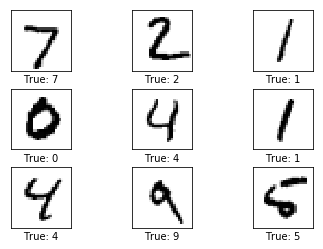

In [13]:
# Get the first images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = data.test.cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

In [14]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)

In [15]:
x_pretty = pt.wrap(x_image)

In [16]:
with pt.defaults_scope(activation_fn=tf.nn.relu):
    y_pred, loss = x_pretty.\
        conv2d(kernel=5, depth=16, name='layer_conv1').\
        max_pool(kernel=2, stride=2).\
        conv2d(kernel=5, depth=36, name='layer_conv2').\
        max_pool(kernel=2, stride=2).\
        flatten().\
        fully_connected(size=128, name='layer_fc1').\
        softmax_classifier(num_classes=num_classes, labels=y_true)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [17]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)

In [18]:
#Performance Measures

In [19]:
y_pred_cls = tf.argmax(y_pred, axis=1)

In [20]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [21]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [22]:
#Saver of the variables of the neural network.
saver = tf.train.Saver(max_to_keep=100)

In [23]:
saver_dir = 'checkpoints/ch05/'

In [24]:
if not os.path.exists(saver_dir):
    os.makedirs(saver_dir)

In [25]:
def get_save_path(net_number):
    return saver_dir + 'network' + str(net_number)

In [26]:
session = tf.Session()

In [27]:
def init_variables():
    session.run(tf.initialize_all_variables())

In [28]:
train_batch_size = 64

In [29]:
def random_batch(x_train, y_train):
    
    #Total number of images in the train-set.
    num_images = len(x_train)
    
    #Create a random index into the training-set.
    idx = np.random.choice(num_images, size=train_batch_size, replace=False)
    
    #Use the random index to select random images and labels.
    x_batch = x_train[idx, :]
    y_batch = y_train[idx, :]
    
    #Return the batch.
    return x_batch, y_batch

In [30]:
#Helper-function to perform optimization iterations.
def optimize(num_iterations, x_train, y_train):
    
    #Start-time used for printing time-usage below.
    start_time = time.time()
    
    for i in range(num_iterations):
        #Get a batch of training example.
        #x_batch now holds a batch of images and
        #y_true_batch are the true labels for those images.
        x_batch, y_true_batch = random_batch(x_train, y_train)
        
        
        #Put the batch into a dict with the proper names
        #for placeholder variables in the Tensorflow graph.
        feed_dict_train = {x:x_batch, y_true:y_true_batch}
        
        #Run the optimizer using this batch of training data.
        #Tensorflow assigns the variables in feed_dict_train
        #to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)
        
        #Print status every 100 itersations and after last iterations.
        if i % 100 == 0:
            
            #Calculate the accuracy on the training-batch.
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            
            #Status-message for printing.
            msg = "Optimazation Iteration:{0:>6}, Training Batch Accuracy:{1:>6.1%}"
            
            print(msg.format(i + 1, acc))
    #ENdtime time
    end_time = time.time()
    
    #Difference between start and end-times.
    time_dif = end_time - start_time
    
    #Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [31]:
#Create ensemble of neural networks

In [32]:
num_networks = 5

num_iterations = 10000

In [33]:
if True:
    
    #For each of the neural networks.
    for i in range(num_networks):
        print("Neural network: {0}".format(i))
        
        #Create a random training-set.Ignore the validation-set.
        x_train, y_train, _, _ = random_training_set()
        
        #Initialize the variables of the Tensorflow graph.
        session.run(tf.global_variables_initializer())
        
        #Optimize the variables using this training-set.
        optimize(num_iterations=num_iterations,
                x_train=x_train,
                y_train=y_train)
        
        #Saver the optimized variables to disk.
        saver.save(sess=session, save_path=get_save_path(i))
        
        print()

Neural network: 0
Optimazation Iteration:     1, Training Batch Accuracy:  4.7%
Optimazation Iteration:   101, Training Batch Accuracy: 90.6%
Optimazation Iteration:   201, Training Batch Accuracy: 92.2%
Optimazation Iteration:   301, Training Batch Accuracy: 92.2%
Optimazation Iteration:   401, Training Batch Accuracy: 89.1%
Optimazation Iteration:   501, Training Batch Accuracy: 92.2%
Optimazation Iteration:   601, Training Batch Accuracy: 95.3%
Optimazation Iteration:   701, Training Batch Accuracy: 96.9%
Optimazation Iteration:   801, Training Batch Accuracy: 95.3%
Optimazation Iteration:   901, Training Batch Accuracy: 95.3%
Optimazation Iteration:  1001, Training Batch Accuracy: 96.9%
Optimazation Iteration:  1101, Training Batch Accuracy: 95.3%
Optimazation Iteration:  1201, Training Batch Accuracy: 95.3%
Optimazation Iteration:  1301, Training Batch Accuracy:100.0%
Optimazation Iteration:  1401, Training Batch Accuracy: 95.3%
Optimazation Iteration:  1501, Training Batch Accura

Optimazation Iteration:  3201, Training Batch Accuracy:100.0%
Optimazation Iteration:  3301, Training Batch Accuracy: 98.4%
Optimazation Iteration:  3401, Training Batch Accuracy: 98.4%
Optimazation Iteration:  3501, Training Batch Accuracy: 96.9%
Optimazation Iteration:  3601, Training Batch Accuracy: 96.9%
Optimazation Iteration:  3701, Training Batch Accuracy:100.0%
Optimazation Iteration:  3801, Training Batch Accuracy:100.0%
Optimazation Iteration:  3901, Training Batch Accuracy: 95.3%
Optimazation Iteration:  4001, Training Batch Accuracy: 98.4%
Optimazation Iteration:  4101, Training Batch Accuracy: 98.4%
Optimazation Iteration:  4201, Training Batch Accuracy:100.0%
Optimazation Iteration:  4301, Training Batch Accuracy:100.0%
Optimazation Iteration:  4401, Training Batch Accuracy: 98.4%
Optimazation Iteration:  4501, Training Batch Accuracy:100.0%
Optimazation Iteration:  4601, Training Batch Accuracy:100.0%
Optimazation Iteration:  4701, Training Batch Accuracy:100.0%
Optimaza

Optimazation Iteration:  6401, Training Batch Accuracy:100.0%
Optimazation Iteration:  6501, Training Batch Accuracy:100.0%
Optimazation Iteration:  6601, Training Batch Accuracy:100.0%
Optimazation Iteration:  6701, Training Batch Accuracy:100.0%
Optimazation Iteration:  6801, Training Batch Accuracy:100.0%
Optimazation Iteration:  6901, Training Batch Accuracy: 98.4%
Optimazation Iteration:  7001, Training Batch Accuracy: 98.4%
Optimazation Iteration:  7101, Training Batch Accuracy:100.0%
Optimazation Iteration:  7201, Training Batch Accuracy:100.0%
Optimazation Iteration:  7301, Training Batch Accuracy:100.0%
Optimazation Iteration:  7401, Training Batch Accuracy:100.0%
Optimazation Iteration:  7501, Training Batch Accuracy:100.0%
Optimazation Iteration:  7601, Training Batch Accuracy:100.0%
Optimazation Iteration:  7701, Training Batch Accuracy:100.0%
Optimazation Iteration:  7801, Training Batch Accuracy:100.0%
Optimazation Iteration:  7901, Training Batch Accuracy:100.0%
Optimaza

Optimazation Iteration:  9601, Training Batch Accuracy:100.0%
Optimazation Iteration:  9701, Training Batch Accuracy:100.0%
Optimazation Iteration:  9801, Training Batch Accuracy:100.0%
Optimazation Iteration:  9901, Training Batch Accuracy:100.0%
Time usage: 0:01:30

Neural network: 4
Optimazation Iteration:     1, Training Batch Accuracy: 14.1%
Optimazation Iteration:   101, Training Batch Accuracy: 85.9%
Optimazation Iteration:   201, Training Batch Accuracy: 93.8%
Optimazation Iteration:   301, Training Batch Accuracy: 95.3%
Optimazation Iteration:   401, Training Batch Accuracy: 96.9%
Optimazation Iteration:   501, Training Batch Accuracy: 96.9%
Optimazation Iteration:   601, Training Batch Accuracy: 89.1%
Optimazation Iteration:   701, Training Batch Accuracy: 92.2%
Optimazation Iteration:   801, Training Batch Accuracy: 96.9%
Optimazation Iteration:   901, Training Batch Accuracy: 96.9%
Optimazation Iteration:  1001, Training Batch Accuracy: 93.8%
Optimazation Iteration:  1101, 

In [34]:
#Helper-functions for calculating and predicting classifications

#Split the data-set in batches of this size to limit RAM usage.
batch_size = 256

def predict_labels(images):
    
    #Number of images.
    num_images = len(images)
    
    #Allocate an array for the predicted labels which
    #will be calualted in batches and filled into this array.
    pred_labels = np.zeros(shape=(num_images, num_classes), dtype=np.float)
    
    
    #Now calculate the predicted labels for the batches.
    #Just iterateing through all the labels.
    
    #The starting index for the next batch is denoted i.
    i = 0
    
    while i < num_images:
        #The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_images)
        
        #Create a feed-dict with the images between index i and j.
        feed_dict = {x:images[i:j, :]}
        
        #Calculate the predicted labels using Tensorflow.
        pred_labels[i:j] = session.run(y_pred, feed_dict=feed_dict)
        
        #Set the start-index for the next batch to the
        #end-index of the current batch.
        i = j
    return pred_labels

In [35]:
def correct_prediction(images, labels, cls_true):
    
    #Calculate the predict labels.
    pred_labels = predict_labels(images=images)
    
    #Calculate the predicted class-number for each image.
    cls_pred = np.argmax(pred_labels, axis=1)
    
    #Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)
    
    return correct

In [36]:
def test_correct():
    return correct_prediction(images=data.test.images,
                             labels=data.test.labels,
                             cls_true=data.test.cls)

In [37]:
def validation_correct():
    return correct_prediction(images=data.validation.images,
                             labels=data.validation.labels,
                             cls_true=data.validation.cls)

In [38]:
#Helper-function for calculatiing the classification accuracy.

In [39]:
def classification_accuracy(correct):
    
    #When averaging a boolean array, False means 0 and True means 1.
    #Number of True /len(correct) which is the same as the classification accuracy.
    return correct.mean()

In [40]:
def test_accuracy():
    
    #Get the array of booleans whether the classifictaions are correct for the test-set.
    correct = test_correct()
    
    #Calculate the classifiction accuracy and return it.
    return classification_accuracy(correct)

In [41]:
def validation_accuracy():
    
    #Get the array of booleans whether the classifications are correct.
    #for the validation-set.
    correct = validation_correct()
    
    #Calculate the classification accuracy and return it.
    return classification_accuracy(correct)

In [42]:
#Results and analysis 

In [43]:
def ensemble_predictions():
    
    #Enpty list of predicted labels for each of the neural networks.
    pred_labels = []
    
    #Classification accuracy on the test-set for each network.
    test_accuracies = []
    
    #Classificiation accuracy on the validation-set for each network.
    val_accuracies = []
    
    #For each neural network in the ensemble.
    for i in range(num_networks):
        #Reloac the variables into the tensorflow graph.
        saver.restore(sess=session, save_path=get_save_path(i))
        
        #Calculate the classification accuracy on the test-set.
        test_acc = test_accuracy()
        
        #Append the classification accuracy to the list.
        test_accuracies.append(test_acc)
        
        #Calculate the classification accuracy on the validation-set.
        val_acc = validation_accuracy()
        
        #Append the classification accuracy to the list.
        val_accuracies.append(val_acc)
        
        #Print status message.
        msg = "Network: {0}.Accuracy on Validation-set:{1:.4f}, Test-set:{2:.4f}"
        
        print(msg.format(i, val_acc, test_acc))
        
        #Calculate the predicted labels for the images in the test-set.
        #This is already calculated in the test_accuracy() above but 
        #it is re-calculated here to keep the code a bit simpler.
        pred = predict_labels(images=data.test.images)
        
        #Append the predicted labels to the list.
        pred_labels.append(pred)
    
    return np.array(pred_labels), np.array(test_accuracies), np.array(val_accuracies)

In [44]:
pred_labels, test_accuracies, val_accuracies = ensemble_predictions()

INFO:tensorflow:Restoring parameters from checkpoints/ch05/network0
Network: 0.Accuracy on Validation-set:0.9946, Test-set:0.9894
INFO:tensorflow:Restoring parameters from checkpoints/ch05/network1
Network: 1.Accuracy on Validation-set:0.9950, Test-set:0.9904
INFO:tensorflow:Restoring parameters from checkpoints/ch05/network2
Network: 2.Accuracy on Validation-set:0.9944, Test-set:0.9886
INFO:tensorflow:Restoring parameters from checkpoints/ch05/network3
Network: 3.Accuracy on Validation-set:0.9932, Test-set:0.9887
INFO:tensorflow:Restoring parameters from checkpoints/ch05/network4
Network: 4.Accuracy on Validation-set:0.9930, Test-set:0.9870


In [45]:
print("Mean test-set accuracy:{0:.4f}".format(np.mean(test_accuracies)))
print("Min test-set accuracy:{0:.4f}".format(np.min(test_accuracies)))
print("Max test-set accuracy:{0:.4f}".format(np.max(test_accuracies)))

Mean test-set accuracy:0.9888
Min test-set accuracy:0.9870
Max test-set accuracy:0.9904


In [46]:
pred_labels.shape

(5, 10000, 10)

In [47]:
#Emsemble predictions

In [48]:
ensemble_pred_labels = np.mean(pred_labels, axis=0)
ensemble_pred_labels.shape

(10000, 10)

In [49]:
ensemble_cls_pred = np.argmax(ensemble_pred_labels, axis=1)
ensemble_cls_pred.shape

(10000,)

In [50]:
ensemble_correct = (ensemble_cls_pred == data.test.cls)

In [51]:
ensemble_incorrect = np.logical_not(ensemble_correct)

In [52]:
#Best neural network

In [53]:
test_accuracies

array([0.9894, 0.9904, 0.9886, 0.9887, 0.987 ])

In [54]:
best_net = np.argmax(test_accuracies)
best_net

1

In [55]:
test_accuracies[best_net]

0.9904

In [56]:
best_net_pred_labels = pred_labels[best_net, :, :]

In [57]:
best_net_cls_pred = np.argmax(best_net_pred_labels, axis=1)

In [58]:
best_net_correct = (best_net_cls_pred == data.test.cls)

In [59]:
best_net_incorrect = np.logical_not(best_net_correct)

In [60]:
#Comparison of ensemble vs the best single network.

In [61]:
np.sum(ensemble_correct)

9917

In [62]:
np.sum(best_net_correct)

9904

In [63]:
ensemble_better = np.logical_and(best_net_incorrect, ensemble_correct)

In [64]:
ensemble_better.sum()

37

In [65]:
best_net_better = np.logical_and(best_net_correct, ensemble_incorrect)
best_net_better.sum()

24

In [66]:
#Helper-functions for plotting and printing comparisons.

In [67]:
def plot_images_comparison(idx):
    plot_images(images=data.test.images[idx, :],
               cls_true=data.test.cls[idx],
               ensemble_cls_pred=ensemble_cls_pred[idx],
               best_cls_pred=best_net_cls_pred[idx])

In [68]:
def print_labels(labels, idx, num=1):
    
    #Select the relevant labels based on idx.
    labels = labels[idx, :]
    
    #Select the first num labels.
    labels = labels[0:num, :]
    
    #Round numbers to 2 decimal points so they are easier to read.
    labels_rounded = np.round(labels, 2)
    
    #Print the rounded labels.
    print(labels_rounded)

In [69]:
def print_labels_ensemble(idx, **kwargs):
    print_labels(labels=ensemble_pred_labels, idx=idx, **kwargs)

In [70]:
def print_labels_best_net(idx, **kwargs):
    print_labels(labels=best_net_pred_labels, idx=idx, **kwargs)

In [71]:
def print_labels_all_nets(idx):
    for i in range(num_networks):
        print_labels(labels=pred_labels[i, :, :], idx=idx, num=1)

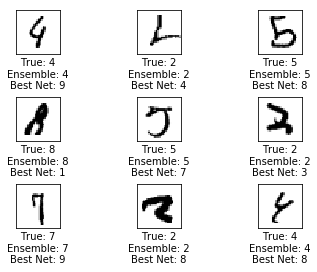

In [72]:
plot_images_comparison(idx=ensemble_better)

In [74]:
print_labels_ensemble(idx=ensemble_better, num=1)

[[0.   0.   0.   0.   0.58 0.   0.   0.   0.   0.41]]


In [75]:
print_labels_best_net(idx=ensemble_better, num=1)

[[0.   0.   0.   0.   0.31 0.   0.   0.   0.   0.69]]


In [76]:
print_labels_all_nets(idx=ensemble_better)

[[0.   0.   0.   0.   0.67 0.   0.   0.   0.   0.33]]
[[0.   0.   0.   0.   0.31 0.   0.   0.   0.   0.69]]
[[0.   0.   0.   0.   0.04 0.   0.   0.   0.   0.95]]
[[0.   0.   0.   0.   0.91 0.   0.   0.   0.   0.09]]
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


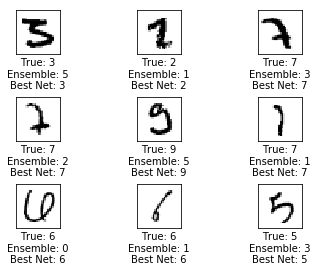

In [77]:
plot_images_comparison(idx=best_net_better)

In [78]:
print_labels_ensemble(idx=best_net_better, num=1)

[[0.  0.  0.  0.5 0.  0.5 0.  0.  0.  0. ]]


In [79]:
print_labels_best_net(idx=best_net_better, num=1)

[[0.   0.   0.   0.91 0.   0.09 0.   0.   0.   0.  ]]


In [80]:
print_labels_all_nets(idx=best_net_better)

[[0.   0.   0.   0.23 0.   0.77 0.   0.   0.   0.  ]]
[[0.   0.   0.   0.91 0.   0.09 0.   0.   0.   0.  ]]
[[0.   0.   0.   0.87 0.   0.13 0.   0.   0.   0.  ]]
[[0.   0.   0.   0.46 0.   0.54 0.   0.   0.   0.  ]]
[[0.   0.   0.   0.02 0.   0.98 0.   0.   0.   0.  ]]


In [81]:
session.close()